In [99]:
import os 
import cv2
import PIL
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import flow_to_image
from dataloader.RAFT_dataloder import get_loader

In [100]:
loader = get_loader('./data/', 5, 'test', num_workers=4, shuffle=False)
input_img, gt_img, _, _ = next(iter(loader))

test RAFT based Warping DataLoader: 5 batch,  input 2 frames output 1 frames
input: 2 frames, torch.Size([5, 3, 520, 960]),   gt: torch.Size([5, 3, 520, 960]),  torch.float32,  0.3393


In [202]:
i0 = input_img[0][4].unsqueeze(0)
i1 = input_img[1][4].unsqueeze(0)
gt = gt_img[4].unsqueeze(0)
print(i0.shape)

torch.Size([1, 3, 520, 960])


In [203]:
path = './output/zglider/'

f01 = torch.tensor(np.load(path+'f01.npy')).unsqueeze(0)
f10 = torch.tensor(np.load(path+'f10.npy')).unsqueeze(0)
ft0gt = torch.tensor(np.load(path+'ft0gt.npy')).unsqueeze(0)
ft1gt = torch.tensor(np.load(path+'ft1gt.npy')).unsqueeze(0)

print(f01.shape, f01.mean(), f01.min(), f01.max(), f01.dtype, type(f01))

torch.Size([1, 2, 520, 960]) tensor(14.0098) tensor(-21.9406) tensor(37.0775) torch.float32 <class 'torch.Tensor'>


In [240]:
def view_flow(flow):
    topilimage = torchvision.transforms.ToPILImage()
    flow_img = flow_to_image(flow)
    flow_img = topilimage(flow_img)
    flow_img = cv2.cvtColor(np.asarray(flow_img), cv2.COLOR_BGR2HSV)
    plt.imshow(flow_img)
    plt.show()

def batch_forward_warping_tensor(flow):
    flow = flow*0.5
    batch, channels, height, width = flow.size()
    warped_image = torch.zeros_like(flow)

    grid_x, grid_y = torch.meshgrid(torch.arange(width), torch.arange(height))
    grid_x = grid_x.float().T
    grid_y = grid_y.float().T

    flow_x = flow[:, 0]
    flow_y = flow[:, 1]

    new_x = grid_x.unsqueeze(0).expand(batch, -1, -1) + flow_x
    new_y = grid_y.unsqueeze(0).expand(batch, -1, -1) + flow_y

    valid_mask = (new_x >= 0) & (new_x < width) & (new_y >= 0) & (new_y < height)

    new_x = new_x.clamp(0, width - 1)
    new_y = new_y.clamp(0, height - 1)

    for b in range(batch):
        for c in range(channels):
            warped_image[b, c, valid_mask[b]] = flow[b, c].reshape(height,width)[new_y[b, valid_mask[b]].long(), new_x[b, valid_mask[b]].long()]

    return warped_image

def calculate_distance(x, y):
    distance = math.sqrt(x**2 + y**2)
    return distance

def plot_histogram(data, bins=10):
    plt.hist(data, bins=bins)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()

def find_hole_base(img, flow):
    batch, channels, height, width = img.size()
    warped_img = torch.zeros_like(img)

    grid_x, grid_y = torch.meshgrid(torch.arange(width), torch.arange(height))
    grid_x = (grid_x.float().T)
    grid_y = (grid_y.float().T)

    flow_x = flow[:, 0]
    flow_y = flow[:, 1]

    # 픽셀 값이 할당 될 새로운 좌표.
    new_x = grid_x.unsqueeze(0).expand(batch, -1, -1) + flow_x
    new_y = grid_y.unsqueeze(0).expand(batch, -1, -1) + flow_y
    print(new_x, new_x.shape)

    # 유효성 검사. : "걸러지는 플로우는 이미지 밖을 향하는 플로우이다."
    valid_mask = (new_x >= 0) & (new_x < width) & (new_y >= 0) & (new_y < height)
    print(valid_mask, valid_mask.shape)

    # 어차피 걸러질거지만, 바운더리 값으로 대치
    new_x = new_x.clamp(0, width - 1)
    new_y = new_y.clamp(0, height -1)

    print(new_x, new_x.shape)

    for b in range(batch):
        for c in range(channels):
            warped_img[b, c, valid_mask[b]] \
                = img[b, c][new_y[b, valid_mask[b]].long(), new_x[b, valid_mask[b]].long()]
                    
    print(new_x[b, valid_mask[b]])

    return warped_img

def find_hole(img, flow):
    batch, channels, height, width = img.size()
    warped_img = torch.zeros_like(img)

    grid_x, grid_y = torch.meshgrid(torch.arange(width), torch.arange(height))
    grid_x = (grid_x.float().T)
    grid_y = (grid_y.float().T)

    flow_x = flow[:, 0]
    flow_y = flow[:, 1]

    # 픽셀 값이 할당 될 새로운 좌표.
    new_x = grid_x.unsqueeze(0).expand(batch, -1, -1) + flow_x
    new_y = grid_y.unsqueeze(0).expand(batch, -1, -1) + flow_y
    print(new_x, new_x.shape)

    # 유효성 검사. : "걸러지는 플로우는 이미지 밖을 향하는 플로우이다."
    valid_mask = (new_x >= 0) & (new_x < width) & (new_y >= 0) & (new_y < height)
    print(valid_mask, valid_mask.shape)

    # 어차피 걸러질거지만, 바운더리 값으로 대치
    new_x = new_x.clamp(0, width - 1)
    new_y = new_y.clamp(0, height -1)

    print(new_x, new_x.shape)

    for b in range(batch):
        for c in range(channels):
            for h in range(height):
                for w in range(width):
                    warped_img[b, c, valid_mask[height, width]] \
                        = img[b, c][new_y[b, valid_mask[height, width]].long(), new_x[b, valid_mask[height, width]].long()]
                    
    print(new_x[b, valid_mask[b]])

    return warped_img


In [ ]:
zero_to_one = find_hole(i1, f01)
zero_to_one_back_to_zero = find_hole(zero_to_one, f10)

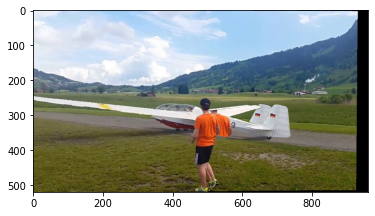

In [234]:
plt.imshow(zero_to_one[0].permute(1,2,0))
plt.show()

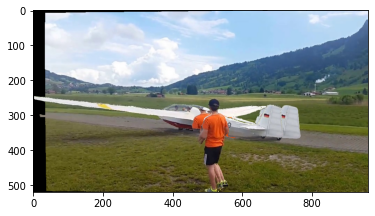

In [235]:
plt.imshow(zero_to_one_back_to_zero[0].permute(1,2,0))
plt.show()

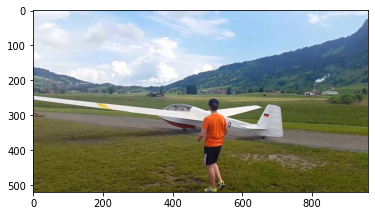

In [236]:
plt.imshow(i1[0].permute(1,2,0))
plt.show()

In [241]:
forwarp = find_hole(i0, ft0gt)
# backwarp = find_hole(i1, ft1gt)
print(forward.shape)


tensor([[[-17.2484, -16.2838, -15.2995,  ..., 941.2445, 942.2531, 943.2731],
         [-17.2813, -16.3040, -15.3120,  ..., 941.2365, 942.2445, 943.2587],
         [-17.2902, -16.3060, -15.3109,  ..., 941.2303, 942.2384, 943.2537],
         ...,
         [-19.2402, -18.2495, -17.2541,  ..., 939.9025, 940.9046, 941.9204],
         [-19.2090, -18.2368, -17.2408,  ..., 939.9100, 940.9126, 941.9333],
         [-19.1430, -18.2058, -17.2140,  ..., 939.9094, 940.9167, 941.9463]]]) torch.Size([1, 520, 960])
tensor([[[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]]]) torch.Size([1, 520, 960])
tensor([[[  0.0000,   0.0000,   0.0000,  ..., 941.2445, 942.2531, 943.2731],
         [  0.0000,   0

IndexError: index 520 is out of bounds for dimension 0 with size 1

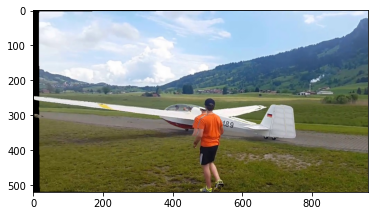

In [238]:
plt.imshow(forwarp[0].permute(1,2,0))
plt.show()

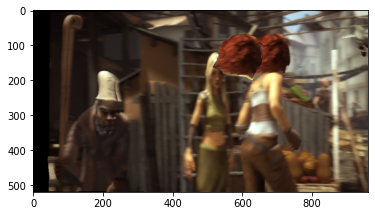

In [239]:
plt.imshow(backwarp[0].permute(1,2,0))
plt.show()

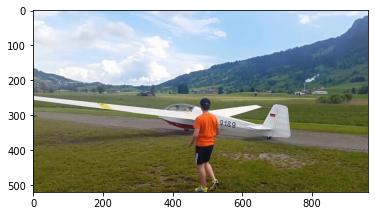

In [211]:
plt.imshow(i0[0].permute(1,2,0))
plt.show()

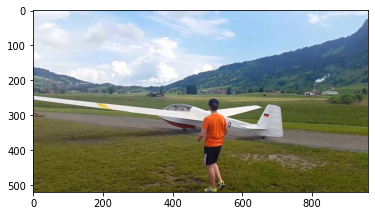

In [212]:
plt.imshow(i1[0].permute(1,2,0))
plt.show()

torch.Size([1, 2, 520, 960])


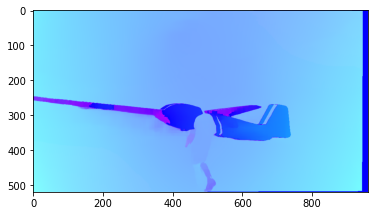

In [213]:
ft1 = batch_forward_warping_tensor(f01)
print(ft1.shape)
view_flow(ft1[0])

torch.Size([1, 2, 520, 960])


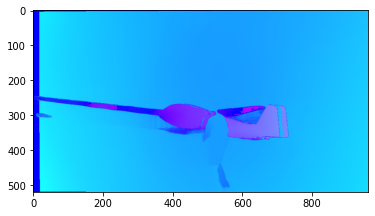

In [214]:
ft0 = batch_forward_warping_tensor(f10)
print(ft0.shape)
view_flow(ft0[0])

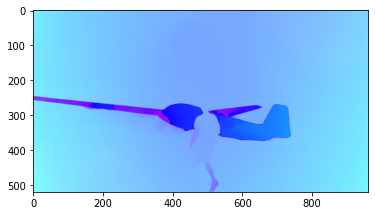

In [215]:
view_flow(f01[0])

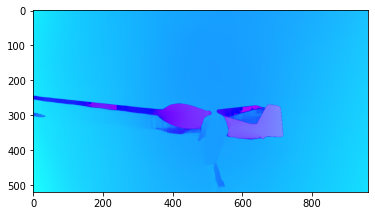

In [216]:
view_flow(f10[0])

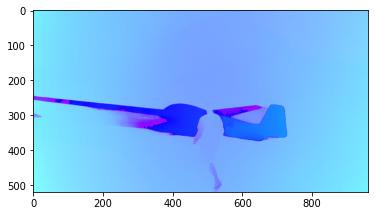

In [217]:
view_flow(ft1gt[0])

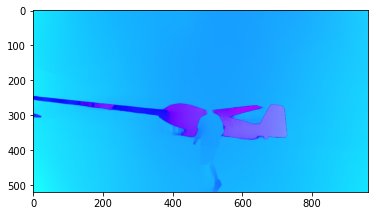

In [218]:
view_flow(ft0gt[0])

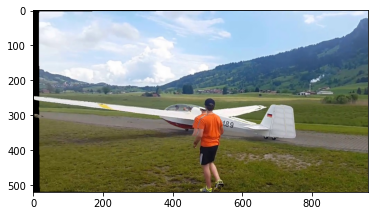

In [219]:
plt.imshow(forwarp[0].permute(1,2,0))
plt.show()

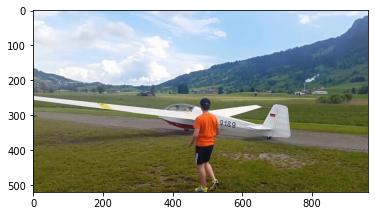

In [220]:
plt.imshow(i0[0].permute(1,2,0))
plt.show()